
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.10?urlpath=lab/tree/cwt.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[cwt.ipynb](../_static/notebooks/cwt.ipynb) |
[cwt.py](../_static/notebooks/cwt.py)
</div>


# CWT Algorithm

This notebook tutorial shows how to work with `CWT` algorithm for detecting gamma-ray sources.

You can find the [docs here](../api/gammapy.detect.CWT.rst#gammapy.detect.CWT)
and [source code on GitHub here](https://github.com/gammapy/gammapy/blob/master/gammapy/detect/cwt.py) for better understanding how the algorithm is constructed. 

## Setup

On this section we just import some packages that can be used (or maybe not) in this tutorial. You can also see the versions of the packages in the outputs below and notice that this notebook was written on Python 2.7. Don't worry about that because the code is also Python 3 compatible. 

In [1]:
# Render our plots inline
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from astropy.io import fits
from astropy.coordinates import Angle, SkyCoord
from gammapy.maps import Map
from gammapy.detect import CWTKernels, CWT, CWTData

## CWT Algorithm

First of all we import the data which should be analysied.

In [3]:
counts = Map.read("$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-counts.fits.gz")

background = Map.read(
    "$GAMMAPY_DATA/fermi-3fhl-gc/fermi-3fhl-gc-background.fits.gz"
)

maps = {"counts": counts, "background": background}

In [4]:
fig = plt.figure(figsize=(15, 3))

ax = fig.add_subplot(121, projection=maps["counts"].geom.wcs)
maps["counts"].plot(vmax=8, ax=ax)

ax = fig.add_subplot(122, projection=maps["background"].geom.wcs)
maps["background"].plot(vmax=8, ax=ax);

Let's explore how CWT works. At first define parameters of the algorithm.  An imperative parameter is kernels (`detect.CWTKernels` object). So we should create it.

In [5]:
# Input parameters for CWTKernels
N_SCALE = 2  # Number of scales considered.
MIN_SCALE = 6.0  # First scale used.
STEP_SCALE = 1.3  # Base scaling factor.

In [6]:
cwt_kernels = CWTKernels(
    n_scale=N_SCALE, min_scale=MIN_SCALE, step_scale=STEP_SCALE
)
cwt_kernels.info_table

<Table length=13>
                     Name                              Source        
                    str46                              str32         
---------------------------------------------- ----------------------
                              Number of scales                      2
                                 Minimal scale                    6.0
                                    Step scale                    1.3
                                        Scales              [6.  7.8]
                          Kernels approx width                     83
                            Kernels approx sum     0.9999153345163221
                            Kernels approx max  0.0015479047097235869
              Kernels base width for 6.0 scale                     63
                Kernels base sum for 6.0 scale 3.0166320971388447e-05
                Kernels base max for 6.0 scale  8.599470609575481e-05
Kernels base width for 7.800000000000001 scale                     83
  Kernels base sum for 7.800000000000001 scale  1.456141213300368e-05
  Kernels base max for 7.800000000000001 scale 3.0109136968507695e-05

Other parameters are optional, in this demonstration define them all.

In [7]:
MAX_ITER = 10  # The maximum number of iterations of the CWT algorithm.
TOL = 1e-5  # Tolerance for stopping criterion.
SIGNIFICANCE_THRESHOLD = 2.0  # Measure of statistical significance.
SIGNIFICANCE_ISLAND_THRESHOLD = (
    None
)  # Measure is used for cleaning of isolated pixel islands.
REMOVE_ISOLATED = True  # If True, isolated pixels will be removed.
KEEP_HISTORY = True  # If you want to save images of all the iterations

Let's start to analyse input data. Import Logging module to see how the algorithm works during data analysis.

In [8]:
cwt = CWT(
    kernels=cwt_kernels,
    tol=TOL,
    significance_threshold=SIGNIFICANCE_THRESHOLD,
    significance_island_threshold=SIGNIFICANCE_ISLAND_THRESHOLD,
    remove_isolated=REMOVE_ISOLATED,
    keep_history=KEEP_HISTORY,
)

In order to the algorithm was able to analyze source images, you need to convert them to a special format, i.e. create an CWTData object. Do this.

In [9]:
cwt_data = CWTData(
    counts=maps["counts"], background=maps["background"], n_scale=N_SCALE
)

In [10]:
# Start the algorithm
cwt.analyze(cwt_data)

## Results of analysis

Look at the results of CWT algorithm. Print all the images.

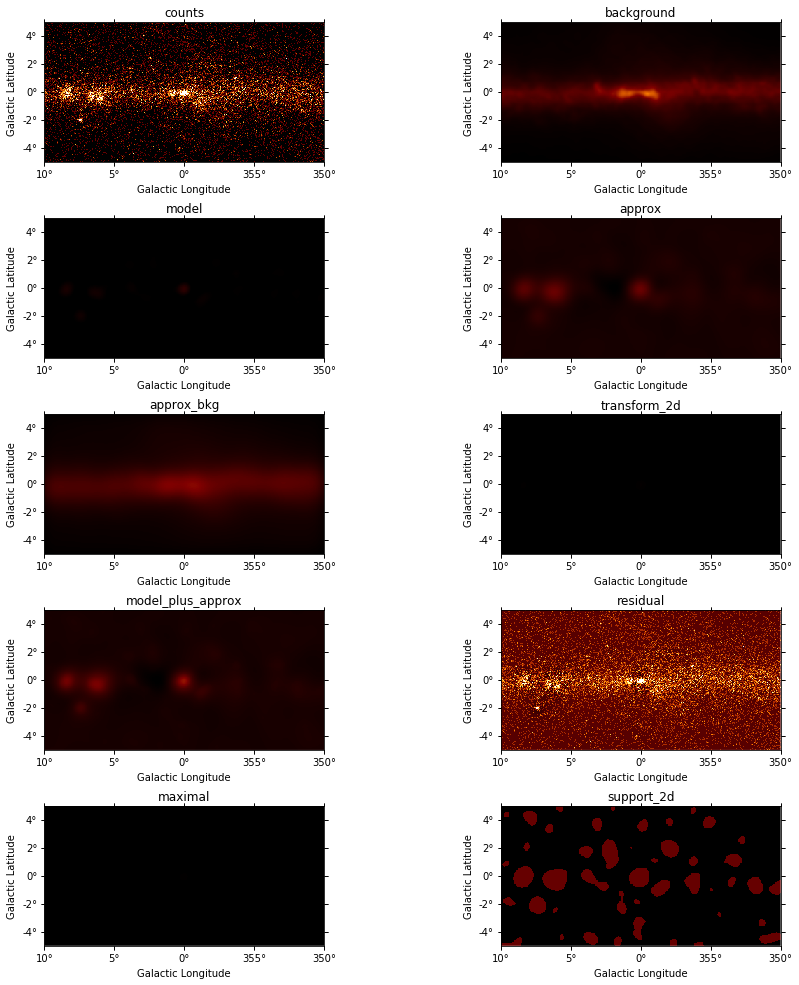

In [11]:
PLOT_VALUE_MAX = 5
FIG_SIZE = (15, 35)

fig = plt.figure(figsize=FIG_SIZE)
images = cwt_data.images()
for index, (name, image) in enumerate(images.items()):
    ax = fig.add_subplot(len(images), 2, index + 1, projection=image.geom.wcs)
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name)  # Maybe add a Name in SkyImage.plots?

plt.subplots_adjust(hspace=0.4)

As you can see in the implementation of CWT above, it has the parameter `keep_history`. If you set to it `True`-value, it means that CWT would save all the images from iterations. Algorithm keeps images of only last CWT start.  Let's do this in the demonstration.

In [12]:
history = cwt.history
print(
    "Number of iterations: {0}".format(len(history) - 1)
)  # -1 because CWT save start images too

Number of iterations: 10


Let's have a look, what's happening with images after the first iteration.

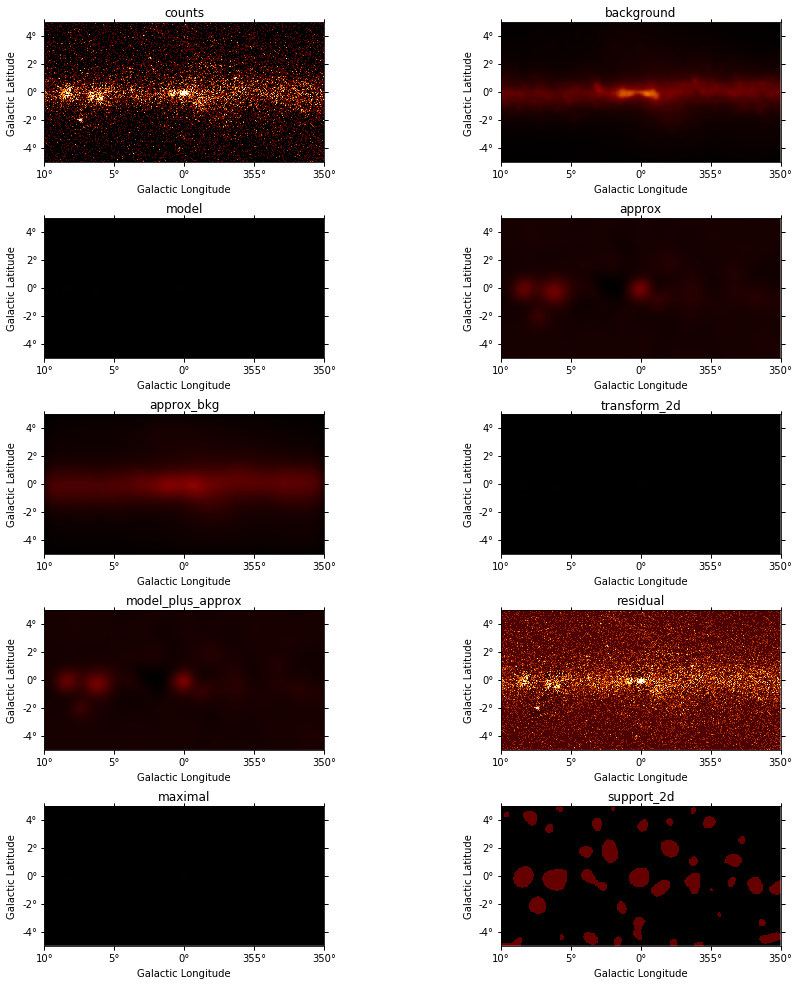

In [13]:
N_ITER = 1
assert 0 < N_ITER < len(history)
data_iter = history[N_ITER]

fig = plt.figure(figsize=FIG_SIZE)
images_iter = data_iter.images()
for index, (name, image) in enumerate(images_iter.items()):
    ax = fig.add_subplot(
        len(images_iter), 2, index + 1, projection=image.geom.wcs
    )
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name)  # Maybe add a Name in SkyImage.plots?

plt.subplots_adjust(hspace=0.4)

You can get the information about the one particular image in that way: 

In [14]:
data_iter.image_info(name="approx_bkg")

<Table length=7>
 Metrics          Source      
  str10           str19       
---------- -------------------
      Name          approx_bkg
     Shape            2D image
  Variance 0.06792041028304846
      Mean  0.3450471835001858
 Max value  1.3431556509385707
 Min value 0.02507055240537183
Sum values  27603.774680014863

You can also get the information about cubes. Or information about all the data. 

In [15]:
data_iter.cube_info(name="support", per_scale=True)

<Table masked=True length=14>
Scale power  Metrics          Source      
   int64      str10           str19       
----------- ---------- -------------------
          1       Name             support
         --      Shape            2D image
         --   Variance    0.08244281109375
         --       Mean           0.0906625
         --  Max value                True
         --  Min value               False
         -- Sum values                7253
          2       Name             support
         --      Shape            2D image
         --   Variance 0.10431465234374998
         --       Mean           0.1183125
         --  Max value                True
         --  Min value               False
         -- Sum values                9465

In [16]:
data_iter.cube_info(name="support", per_scale=False)

<Table length=7>
 Metrics          Source      
  str10           str19       
---------- -------------------
      Name             support
     Shape             3D cube
  Variance 0.09356986234375002
      Mean           0.1044875
 Max value                True
 Min value               False
Sum values               16718

Also you can see the difference betwen the iterations in that way:

In [17]:
history = cwt.history  # get list of 'CWTData' objects
difference = (
    history[1] - history[0]
)  # get new `CWTData` obj, let's work with them

In [18]:
difference.cube_info("support")

<Table length=7>
 Metrics          Source      
  str10           str19       
---------- -------------------
      Name             support
     Shape             3D cube
  Variance 0.09356986234375002
      Mean           0.1044875
 Max value                True
 Min value               False
Sum values               16718

In [19]:
difference.info_table.show_in_notebook()

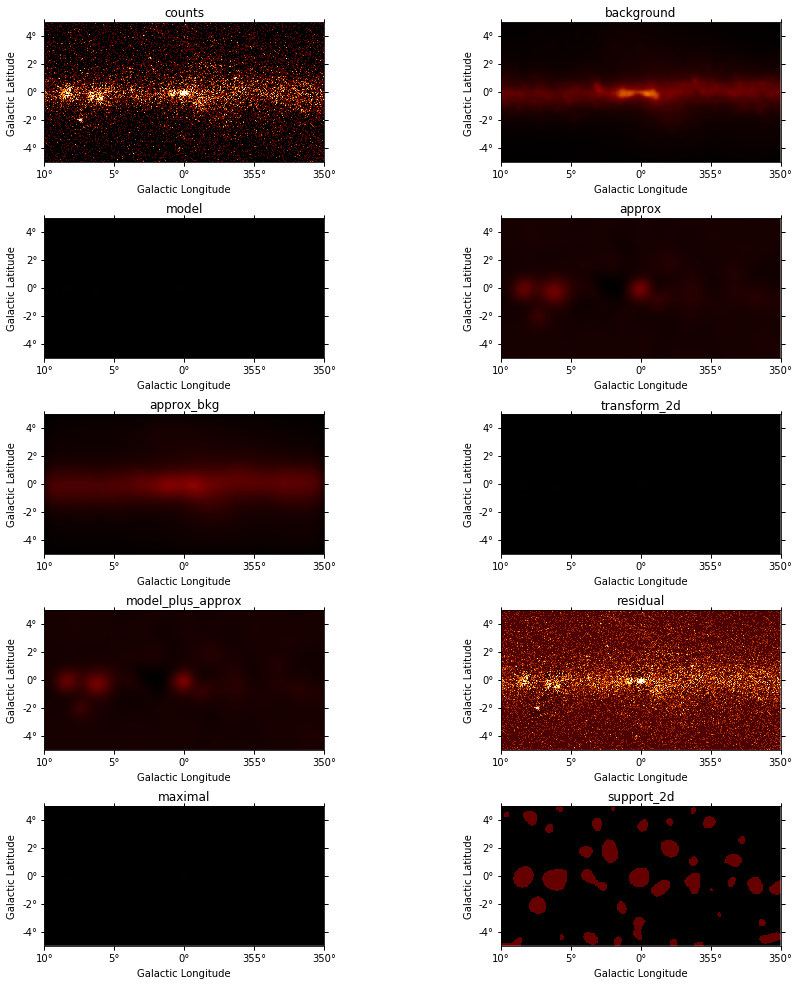

In [20]:
fig = plt.figure(figsize=FIG_SIZE)
images_diff = difference.images()
for index, (name, image) in enumerate(images_diff.items()):
    ax = fig.add_subplot(
        len(images_diff), 2, index + 1, projection=image.geom.wcs
    )
    image.plot(vmax=PLOT_VALUE_MAX, fig=fig, ax=ax)
    plt.title(name)  # Maybe add a Name in SkyImage.plots?

    plt.subplots_adjust(hspace=0.4)

You can save the results if you want

In [21]:
# cwt_data.write('test-cwt.fits', True)